Create a simple 2-class classification task (non-linear boundary)

Try 2 models:
Underfit Model: Too simple
Overfit Model: Too complex on small data

In [25]:
import torch

import torch.nn as nn

import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split

In [26]:
# Generate synthetic non-linear data

X,y = make_moons(n_samples=300, noise=0.25, random_state=42)

X = torch.tensor(X, dtype=torch.float32)

y = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

In [27]:
# Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

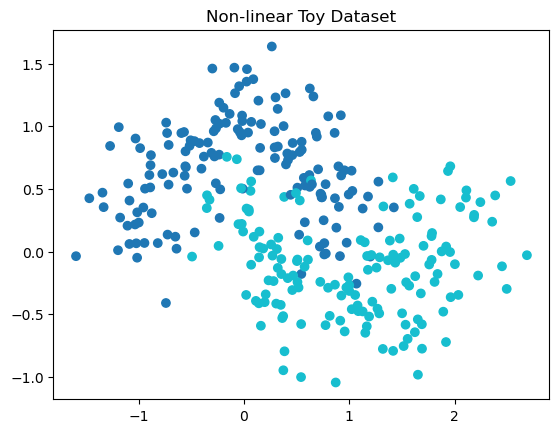

In [28]:
# Plot data

plt.scatter(X[:,0], X[:,1], c=y[:,0], cmap='tab10')

plt.title("Non-linear Toy Dataset")

plt.show()

🤏 Model 1: Underfitting

In [ ]:
class UnderfitNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(2,1) # Just a linear model

    def forward(self,x):

        return torch.sigmoid(self.fc(x))

In [ ]:
underfit_model = UnderfitNet()

loss_fn = nn.BCELoss()

optimizer = optim.SGD()